In [1]:
#检测GPU可用性
import tensorflow as tf
from tensorflow import keras
print(tf.test.is_gpu_available())

True


In [2]:
#加载CAIFAR10数据
from pandas import DataFrame
data=keras.datasets.cifar10.load_data()
data=DataFrame(data)
data.head(10)

170498071/170498071 [==============================] - 6s 0us/step


,0,1
0,"[[[[59 62 63], [43 46 45], [50 48 43], [68 54 ...","[[6], [9], [9], [4], [1], [1], [2], [7], [8], ..."
1,"[[[[158 112 49], [159 111 47], [165 116 51]...","[[3], [8], [8], [0], [6], [6], [1], [6], [3], ..."


In [3]:
print('数据集规模为:',data.shape)

数据集规模为: (2, 2)


In [4]:
train_image=data.iloc[0,0][:50000]
train_image_target=data.iloc[0,1][:50000]
valid_image=data.iloc[1,0][:5000]
valid_image_target=data.iloc[1,1][:5000]
test_image=data.iloc[1,0][5000:]
test_image_target=data.iloc[1,1][5000:]
print('训练集规模:',train_image.shape)
print('训练集标签:',train_image_target.shape)
print('验证集规模:',valid_image.shape)
print('验证集标签:',valid_image_target.shape)
print('测试集规模:',test_image.shape)
print('测试集标签:',test_image_target.shape)

训练集规模: (50000, 32, 32, 3)
训练集标签: (50000, 1)
验证集规模: (5000, 32, 32, 3)
验证集标签: (5000, 1)
测试集规模: (5000, 32, 32, 3)
测试集标签: (5000, 1)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  This is separate from the ipykernel package so we can avoid doing imports until


<AxesSubplot:ylabel='Density'>

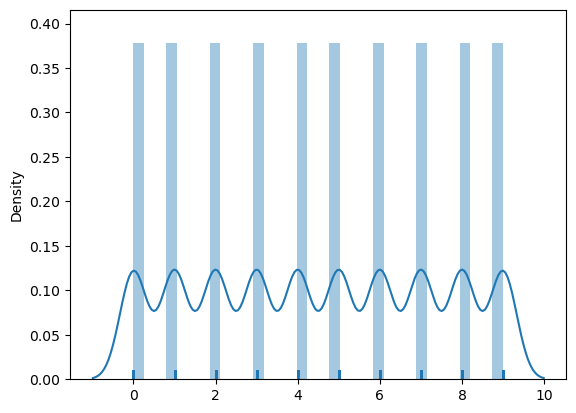

In [5]:
#查看数据分布
import seaborn as sns
sns.distplot(train_image_target,hist=True,kde=True,rug=True)    #训练集

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:ylabel='Density'>

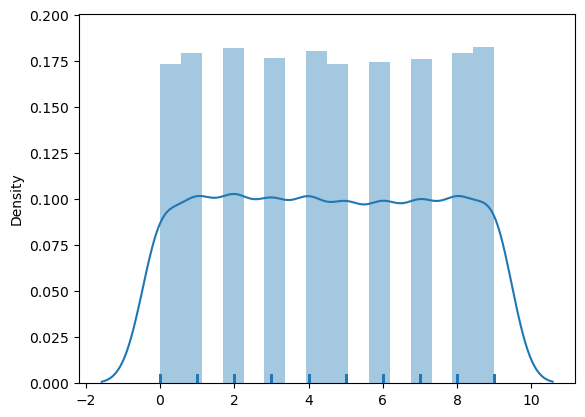

In [6]:
sns.distplot(valid_image_target,hist=True,kde=True,rug=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:ylabel='Density'>

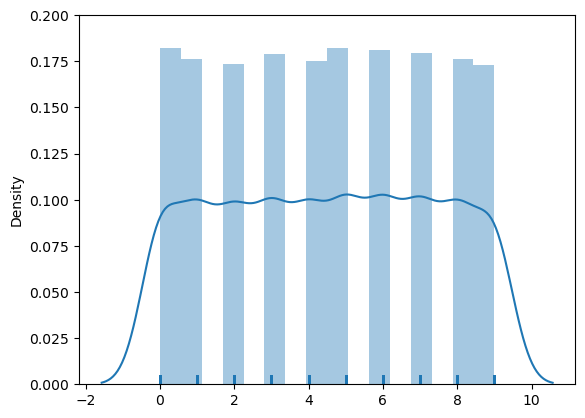

In [7]:
sns.distplot(test_image_target,hist=True,kde=True,rug=True)  #测试集

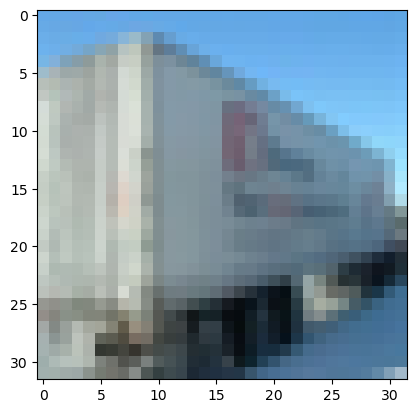

In [8]:
#可视化数据
import matplotlib.pyplot as plt
plt.imshow(train_image[15])

In [9]:
#归一化数据标签
import numpy as np
classes_name=np.array(['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'])    #定义数据标签
print(classes_name[train_image_target[15]])

['truck']


In [10]:
#数据预处理函数
def propress(image,target):
    image=tf.cast(image,tf.float32)/255
    target=target
    return image,target

In [11]:
#使用数据集API加载数据
Train_Data=tf.data.Dataset.from_tensor_slices((train_image,train_image_target))
Test_Data=tf.data.Dataset.from_tensor_slices((test_image,test_image_target))
Valid_Data=tf.data.Dataset.from_tensor_slices((valid_image,valid_image_target))
Train_Data=Train_Data.map(propress)    #打乱数据集
Train_Data=Train_Data.repeat(10)    
Train_Data=Train_Data.shuffle(buffer_size=2000,seed=1234).batch(250).prefetch(1)    #验证集数据处理
Valid_Data=Valid_Data.map(propress)
Valid_Data=Valid_Data.repeat(10)
Valid_Data=Valid_Data.shuffle(buffer_size=2000,seed=1234).batch(250).prefetch(1)
Test_Data=Test_Data.repeat(10)     #测试集数据预处理
Test_Data=Test_Data.map(propress)
Test_Data=Test_Data.shuffle(buffer_size=2000).batch(250).prefetch(1)

In [30]:
#构造卷积神经网络
model=keras.models.Sequential()    #模型组网
model.add(keras.layers.Conv2D(filters=32,kernel_size=(3,3),strides=1,padding='VALID',activation='selu',input_shape=(32,32,3),name='input_layer'))    #三层卷积操作
model.add(keras.layers.MaxPooling2D(2,2))
model.add(keras.layers.Conv2D(filters=64,kernel_size=(2,2),activation='selu',padding='VALID',name='CNN_layer'))
model.add(keras.layers.Conv2D(filters=128,kernel_size=(2,2),activation='selu',padding='VALID'))
model.add(keras.layers.MaxPooling2D(2,2))
model.add(keras.layers.Conv2D(filters=256,kernel_size=(2,2),activation='selu',padding='VALID'))
model.add(keras.layers.Conv2D(filters=512,kernel_size=(2,2),activation='relu',padding='VALID'))
model.add(keras.layers.MaxPooling2D(2,2))
model.add(keras.layers.Reshape((4,512)))    #数据维度转化
model.add(keras.layers.RNN(keras.layers.LSTMCell(50),return_sequences=True,name='LSTM_layer'))    #LSTM层
model.add(keras.layers.RNN(keras.layers.LSTMCell(50),return_sequences=True))
model.add(keras.layers.RNN(keras.layers.LSTMCell(50),return_sequences=True))
model.add(keras.layers.RNN(keras.layers.LSTMCell(50),return_sequences=True))
model.add(keras.layers.RNN(keras.layers.LSTMCell(50),return_sequences=True))
model.add(keras.layers.BatchNormalization())    #数据归一化
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(256,activation='selu',kernel_initializer='lecun_normal',kernel_regularizer=keras.regularizers.l1_l2(0.01,0.01),kernel_constraint=keras.constraints.max_norm(1),name='Dense_layer'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(256,activation='selu',kernel_initializer='lecun_normal',kernel_regularizer=keras.regularizers.l1_l2(0.01,0.01),kernel_constraint=keras.constraints.max_norm(1)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(128,activation='selu',kernel_initializer='lecun_normal',kernel_regularizer=keras.regularizers.l1_l2(0.01,0.01),kernel_constraint=keras.constraints.max_norm(1)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(64,activation='selu',kernel_initializer='lecun_normal',kernel_regularizer=keras.regularizers.l1_l2(0.01,0.01),kernel_constraint=keras.constraints.max_norm(1)))
model.add(keras.layers.Dense(10,activation='softmax',name='output_layer'))
model.summary()    #可视化模型

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (Conv2D)        (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 CNN_layer (Conv2D)          (None, 14, 14, 64)        8256      
                                                                 
 conv2d_47 (Conv2D)          (None, 13, 13, 128)       32896     
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 6, 6, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_48 (Conv2D)          (None, 5, 5, 256)       

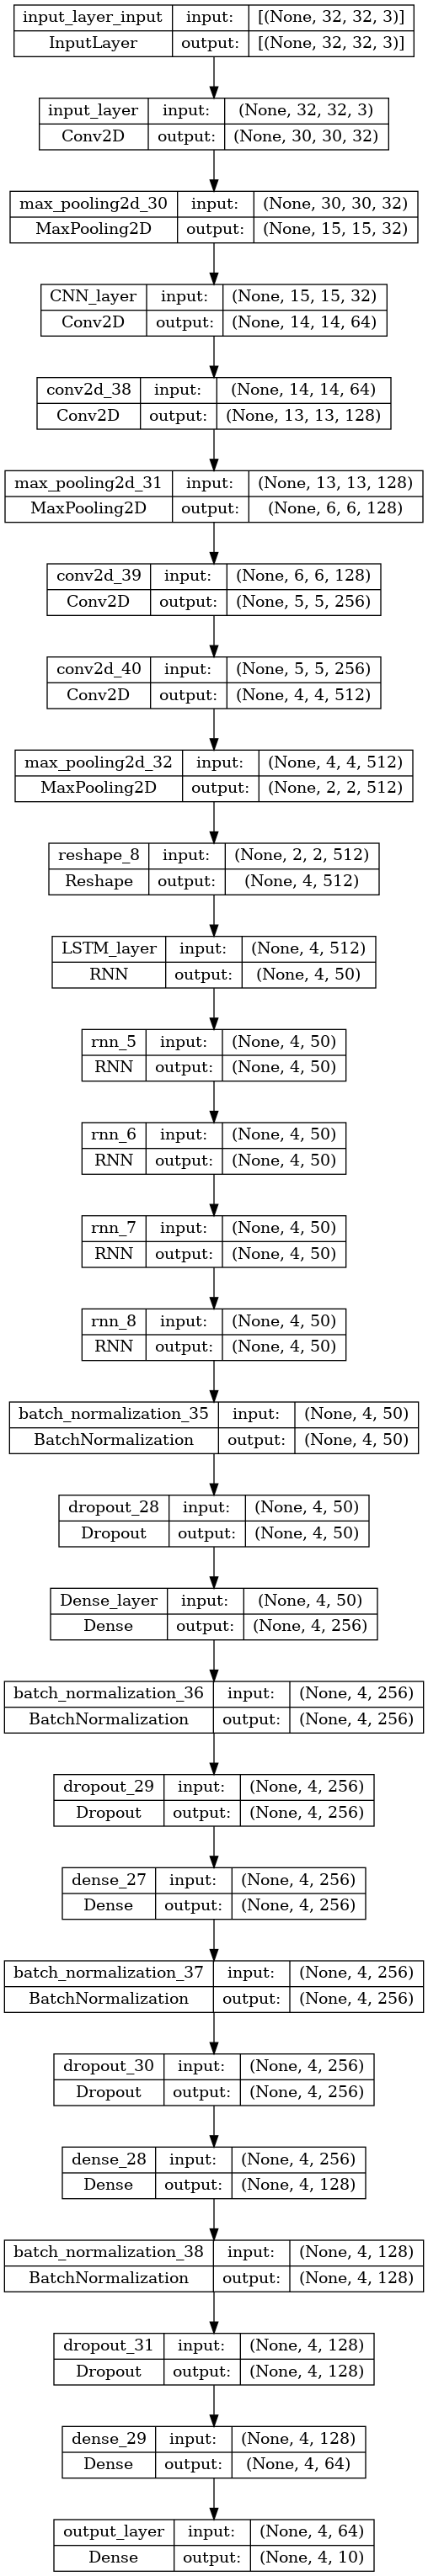

In [25]:
from keras.utils import plot_model
plot_model(model,show_shapes=True)

In [31]:
train_epochs=10
lr_scheduler=keras.callbacks.ReduceLROnPlateau(factor=0.5,patience=10)    #学习率性能调度
CheckPoint_model=keras.callbacks.ModelCheckpoint('model',save_best_only=True)    #设置提前停止
EarlyStopping_model=keras.callbacks.EarlyStopping(patience=500,restore_best_weights=True)
model.compile(loss='sparse_categorical_crossentropy',optimizer=keras.optimizers.Nadam(lr=0.001),metrics=['accuracy'])
model_history=model.fit(Train_Data,epochs=train_epochs,validation_data=Valid_Data,callbacks=[CheckPoint_model,EarlyStopping_model,lr_scheduler])

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert' defined at (most recent call last):
    File "/opt/conda/lib/python3.7/runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "/opt/conda/lib/python3.7/runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.7/site-packages/traitlets/config/application.py", line 978, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.7/asyncio/events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 387, in do_execute
      cell_id=cell_id,
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2975, in run_cell
      raw_cell, store_history, silent, shell_futures, cell_id
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3029, in _run_cell
      return runner(coro)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3472, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3552, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_23/4255702122.py", line 6, in <module>
      model_history=model.fit(Train_Data,epochs=train_epochs,validation_data=Valid_Data,callbacks=[CheckPoint_model,EarlyStopping_model,lr_scheduler])
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 890, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 949, in compute_loss
      y, y_pred, sample_weight, regularization_losses=self.losses)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/opt/conda/lib/python3.7/site-packages/keras/losses.py", line 139, in __call__
      losses = call_fn(y_true, y_pred)
    File "/opt/conda/lib/python3.7/site-packages/keras/losses.py", line 243, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/losses.py", line 1861, in sparse_categorical_crossentropy
      y_true, y_pred, from_logits=from_logits, axis=axis)
    File "/opt/conda/lib/python3.7/site-packages/keras/backend.py", line 5239, in sparse_categorical_crossentropy
      labels=target, logits=output)
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert'
assertion failed: [Condition x == y did not hold element-wise:] [x (sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/Shape_1:0) = ] [250 1] [y (sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/strided_slice:0) = ] [250 4]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert}}]] [Op:__inference_train_function_42686]

In [ ]:
import os
print('CPU核心数:',os.cpu_count())

In [ ]:
from pandas import DataFrame
DataFrame(model_history.history).plot()
plt.title('Learning Curve')
plt.grid(color='black',linestyle='-.',alpha=0.3)
plt.xlabel('train eopchs')
plt.ylabel('error')
plt.show()

In [ ]:
#绘制学习率曲线
import matplotlib.pyplot as plt
Learning_hostory=DataFrame(model_history.history)
fig=plt.figure(figsize=(14,21))
ax1=fig.add_subplot(211)    #绘制误差曲线
ax1.set_title('loss Curve')
ax1.grid(color='black',linestyle='-.',alpha=0.3)
ax1.plot(np.arange(1,train_epochs+1),Learning_hostory['loss'],color='red',marker='.',linestyle='-.',label='Train loss=%f'%Learning_hostory.loc[train_epochs-1,'loss'])
ax1.plot(np.arange(1,train_epochs+1),Learning_hostory['val_loss'],color='blue',marker='.',linestyle='-.',label='Valid loss=%f'%Learning_hostory.loc[train_epochs-1,'val_loss'])
ax1.set_xlabel('Train epochs')
ax1.set_ylabel('loss')
ax1.legend()
ax2=fig.add_subplot(212)    #绘制精度曲线
ax2.set_title('Accuracy Curve')
ax2.grid(color='black',linestyle='-.',alpha=0.3)
ax2.plot(np.arange(1,train_epochs+1),Learning_hostory['accuracy'],color='red',marker='.',linestyle='-.',label='Train accuracy=%f'%Learning_hostory.loc[train_epochs-1,'accuracy'])
ax2.plot(np.arange(1,train_epochs+1),Learning_hostory['val_accuracy'],color='blue',marker='.',linestyle='-.',label='Valid accuracy=%f'%Learning_hostory.loc[train_epochs-1,'val_accuracy'])
ax2.set_xlabel('Train epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

In [ ]:
model.evaluate(Test_Data)    #模型评估

In [ ]:
model.save('ICR_Model_V6.h5')    #保存模型

In [ ]:
test=test_image[10]
plt.imshow(test)

In [ ]:
target=model.predict(test_image[[10]])
target_list=np.argmax(target)
class_name_=classes_name[target_list]
print('图片为:{0},可行度为:{1}'.format(class_name_,target_list))